# 🩺 Exploration 11 Main Project - 폐렴 진단기 성능 개선 🩺

## 📢 진행 순서 📢
1. Set-up
2. 데이터 가져오기
3. 데이터 시각화
4. CNN Modeling
5. 데이터 imbalance 처리
6. 모델 훈련
7. 훈련 결과 확인
8. 특명 : 폐렴 진단기의 성능을 개선하라
9. 프로젝트 회고

## 🎯 루브릭 살펴보기 🎯

|루브릭 평가항목|세부기준|
|------|---|
|<span style="color:red">**의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**</span>|모델 학습이 안정적으로 수렴함을 시각화로 증명할 수 있을 것|
|<span style="color:blue">**데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**</span>|regularization, augmentation 등의 기법을 활용하여 체계적으로 수행될 것|
|<span style="color:purple">**실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**</span>|Accuracy 기준 85%|

## 1. Set-up

- 아래의 명령어를 Cloud Shell에 입력하여 디렉토리를 생성하고 사용할 데이터셋을 불러온다.
- 사용하고자 하는 데이터는 Kaggle에 있는 **Chest X-Ray Images** 이다.

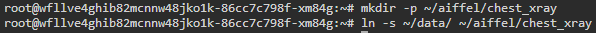

- 필요한 패키지를 불러온다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print('패키지 다 불러왔습니다~')

패키지 다 불러왔습니다~


- 필요한 변수들을 생성한다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 아래의 두 변수는 변경이 가능한 하이퍼 파라미터!
BATCH_SIZE = 32
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

- 데이터는 **train, test, val**로 나누어져 있다.
- 각각에 속한 데이터의 개수를 확인하기 위해 **len()**을 이용한다.

In [3]:
# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드를 활용한다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 별 개수 확인
print('train 데이터의 개수는', len(train_filenames), '개 입니다')
print('test 데이터의 개수는', len(test_filenames), '개 입니다')
print('val 데이터의 개수는', len(val_filenames), '개 입니다')

train 데이터의 개수는 5216 개 입니다
test 데이터의 개수는 624 개 입니다
val 데이터의 개수는 16 개 입니다


- train, test 데이터에 비해 **val 데이터의 개수가 매우 적다.**
- train에서 val에 쓰일 데이터를 더 가져오도록 한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('재조정된 train 데이터의 개수는', len(train_filenames), '개 입니다')
print('재조정된 val 데이터의 개수는', len(val_filenames), '개 입니다')

재조정된 train 데이터의 개수는 4185 개 입니다
재조정된 val 데이터의 개수는 1047 개 입니다


- **test 데이터는 건드리지 않았으므로, 최종 배분은 아래와 같다.**
1. train 데이터 : 4185 개
2. test 데이터 : 624 개
3. val 데이터 : 1047 개

- **train 데이터 안에 있는** 정상 이미지의 수와 폐렴 이미지의 수를 확인해 본다.

In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데, 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


- 파일 경로에 지정 문자열이 있는지를 확인하여 이미지를 세어볼 수 있다.
- 아래 코드를 돌려보면 폐렴 이미지의 개수가 정상보다 약 3배 정도 많이 나왔다.

In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 여가에서는 **CNN 모델을 사용**하게 되는데, **데이터의 클래스별 balance가 좋을수록 training을 잘 한다.**
- 데이터의 클래스 불균형 문제 해결에 대한 내용은 뒤에서 다룬다.
- **test와 val 데이터셋은 학습이 아닌 평가를 위해 사용**되므로 지금 당장 imbalance 하더라도 크게 문제는 없다고 보면 된다.

- **tf.data**는 Tensorflow에서 학습시킬 때 **배치처리 작업을 더 효율적으로 하게 하는 도구**이다.
- tf.data의 인스턴스를 생성한다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- 다시 한 번 train, val 데이터셋의 개수를 확인한다.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지는 **라벨 데이터를 따로 가지고 있지 않다.**
- 파일 경로에 NORMAL이나 PNEUMONIA가 포함되어 있음을 이용해서 라벨 데이터를 만드는 함수를 정의한다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- **이미지 데이터는 사이즈가 제각각인 경우가 많다.**
- 따라서 이미지의 사이즈를 동일하게 맞추고 GPU 메모리를 효율적으로 사용하기 위해 사이즈를 줄여본다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- 이제 train 데이터셋과 val 데이터셋을 만든다.
- num_parallel_calls 파라미터에서, 이전 set-up 과정에서 초기화한 **AUTOTUNE을 이용하여 더 빠르게 데이터를 처리한다.**

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이제 이미지가 잘 resize 되었는지, 라벨이 잘 들어갔는지 확인한다.
- **(180, 180, 3)에서 앞의 두 180은 이전 set-up 과정에서 설정한 X-ray 이미지의 size를 나타낸다.**
- **train_ds.take(1)** : 전체 train 데이터셋의 데이터 중 하나의 데이터만을 가져온다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 이번에는 test 데이터셋을 만들고, 해당 데이터의 개수도 확인해 본다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 **tf.data 파이프라인**을 통해 학습 데이터를 효율적으로 사용할 수 있도록 해 준다.
- 아래 코드 중 **prepare_for_training()** 은 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환시키는 함수로서 정의한다.
- **shuffle()** 을 사용하면 고정 크기의 버퍼를 유지한 채, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택하게 된다.
- **repeat()** 를 사용한 데이터셋은 해당 데이터셋을 여러 번 사용할 수 있게 해주고, 자동으로 데이터를 맞춰주기도 한다. 예를 들어 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다.
- **batch()** 는 하이퍼파라미터였던 BATCH_SIZE에서 정한 만큼의 배치를 부여한다. 예를 들어 100개의 데이터를 10개의 배치로 나눈다면 한 배치당 10개의 데이터로 나뉜다.
- 마지막으로 **prefetch()** 는 학습 데이터를 나눠서 읽어오도록 하는 함수로, 리소스의 유휴 상태를 줄여 효율을 높일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

- 시각화를 수행하기 위해 train에 있는 배치를 하나씩 추출한다.
- 추출한 배치를 image와 label 데이터셋으로 나눈다.
- **show.batch()**를 통해서 결과를 시각화한다.

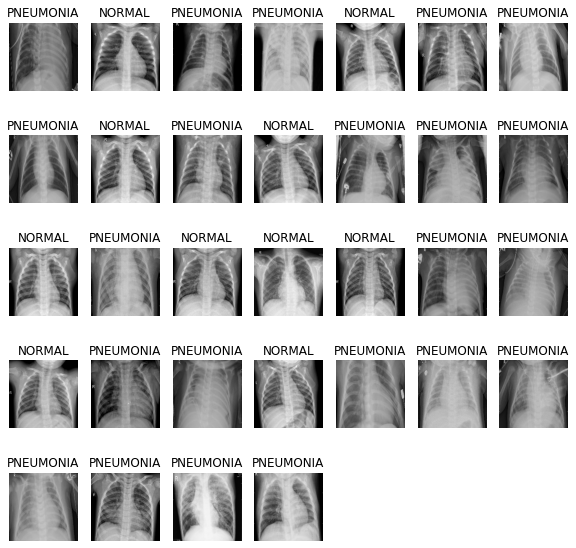

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN Modeling

- 딥러닝의 대표적인 모델인 CNN을 Modeling하고 결과를 만드는 작업이다.
- 먼저, convolution block을 만든다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- dense block도 만든다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 위의 코드를 잘 보면, **Batch Normalization과 Dropout 기법을 하나의 dense_block이라는 함수에 동시에 사용**하고 있음을 알 수 있다.
- 다만, 두 기법을 동시에 사용하는 것이 어울리는지 아닌지에 대해서는 사람마다 다른 견해를 보인다.
1. 성능 향상에 도움이 된다는 이유로 **두 기법을 동시에 사용하는 것을 옹호하는 견해** : https://arxiv.org/pdf/1905.05928.pdf
2. **두 기법을 동시에 사용하는 것은 어울리지 않다는 견해** : variance shift를 억제하는 BN과 이를 유발하는 Dropout (https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

- Batch Normalization과 Dropout 기법을 함께 사용하는 모델이 성능 향상에 도움이 될지를 살펴보는 것도 흥미로운 부분이다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 5. 데이터 imbalace 처리

- 이전에 2번 항목에서 봤을 때, 정상(NORMAL) 데이터보다 **폐렴(PNEUMONIA) 데이터가 3배** 정도 많았었다.
- 이러한 불균형 상태를 **imbalance**라고 한다.
- imbalance한 데이터를 학습시킬 때는 학습 효과가 떨어질 수 있다.
- 이 과정에서 **Weight balancing**이라는 테크닉이 사용된다. 이 방법은 training set의 각 데이터에서 loss를 계산할 때, 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.
- 참고 : https://3months.tistory.com/414
- 아래의 weight들은 NORMAL과 PNEUMONIA 전체 데이터의 건수에 반비례하도록 설정된다.

In [20]:
# weight_for_0 : NORMAL 이미지에 사용할 weight로 세팅
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1 : PNEUMONIA 이미지에 사용할 weight로 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# 딕셔너리 형태로 부여
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

- 이미지 훈련은 GPU를 활용한다.
- CNN Modeling 단계에서 정의된 build_model()을 model에 선언해준다.
- 이미지 라벨이 2개(NORMAL, PNEUMONIA)이므로 binary_crossentropy를 사용한다.
- 성과 측정 metrics로는 accuracy, precision, recall을 사용한다.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 이제, 모델을 fit하는 작업을 해본다. (여기서 출력 완료까지 시간 다소 소요)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 52s 251ms/step - loss: 0.5124 - accuracy: 0.7353 - precision: 0.9302 - recall: 0.6909 - val_loss: 0.5821 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 31s 240ms/step - loss: 0.2180 - accuracy: 0.9123 - precision: 0.9769 - recall: 0.9020 - val_loss: 0.7410 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 32s 248ms/step - loss: 0.1384 - accuracy: 0.9525 - precision: 0.9849 - recall: 0.9503 - val_loss: 0.9735 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 31s 238ms/step - loss: 0.1413 - accuracy: 0.9431 - precision: 0.9811 - recall: 0.9410 - val_loss: 1.2803 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 31s 240ms/step - loss: 0.1308 - accura

## 7. 훈련 결과 확인

- 그래프를 통해 epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해 본다.

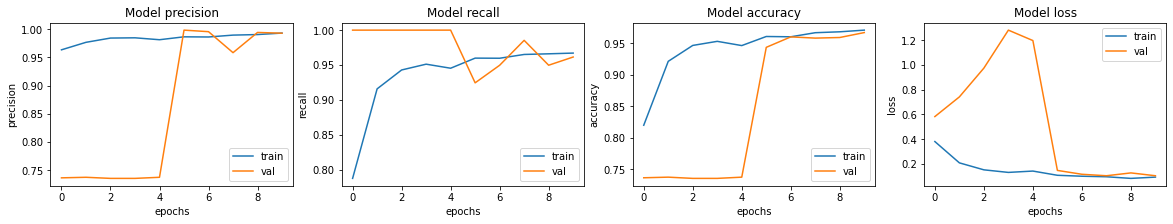

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 마지막으로, 모델 평가 결과를 확인해 본다.
- 모델 fit으로 확인한 accuracy 흐름보다는 낮은 accuracy인 80.13% 정도가 나왔다.
- 이제, 다음 단계에서 이 정확도를 올리기 위해 다양한 시도를 해 볼 것이다.

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 8s 414ms/step - loss: 0.6509 - accuracy: 0.8381 - precision: 0.8017 - recall: 0.9846
Loss: 0.6509302258491516,
Accuracy: 0.8381410241127014,
Precision: 0.8016701340675354,
Recall: 0.9846153855323792


## 8. 특명 : 폐렴 진단기의 성능을 개선하라
- 초기 모델 성능 평가시 **BATCH_SIZE = 32, EPOCHS = 20**이었고 **Accuracy는 약 80.13%** 였다.

### 💛 1번째 시도 💛
- **BATCH_SIZE만 초기의 2배로 증가 (BATCH_SIZE=64)**
- Accuracy 결과(%) : **84.615%**

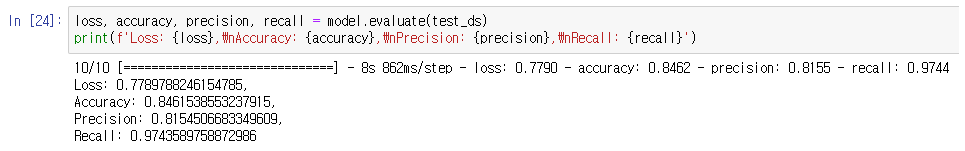

### 💛 2번째 시도 💛
- **BATCH_SIZE만 초기의 4배로 증가 (BATCH_SIZE=128)**
- Accuracy 결과(%) : **62.5%**

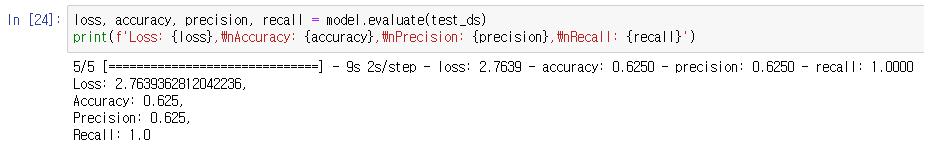

### 💛 3번째 시도 💛
- **BATCH_SIZE는 초기 사이즈와 동일하게 주고, EPOCHS 횟수를 절반으로 줄였다.**
- Accuracy 결과(%) : **81.410%**

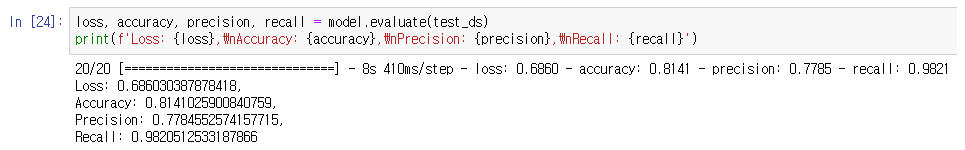

### 💛 4번째 시도 💛
- **3번째 시도에서 어떠한 파라미터도 바꾸지 않고 그대로 한 번 더 모델을 학습한다.**
- Accuracy 결과(%) : **87.98% (루브릭 기준 충족)**

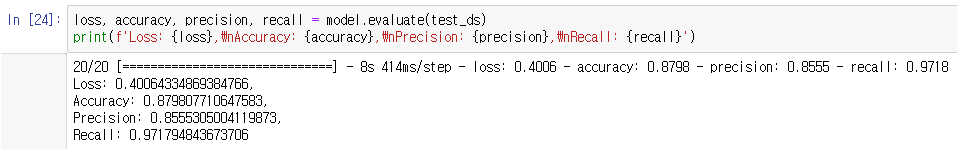

### 💛 5번째 시도 💛
- 이번에도 **3번째 시도와 동일하게** 어떠한 파라미터도 바꾸지 않은 채 그대로 두고 학습한다.
- Accuracy 결과(%) : **86.05%**

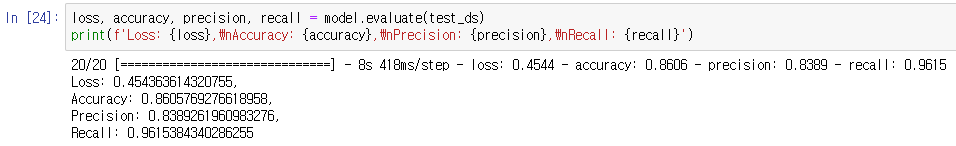

### 💙 중간 점검 💙
- 3번째~5번째 시도는 모두 같은 하이퍼파라미터와 모델 구성으로 시도하였다.
- 그런데 이 동안의 시도에서 모두 다른 값의 Accuracy를 얻었다.
- 그 이유는 정확히는 알지 못하지만, 아마 prepare_for_training에서 shuffle_buffer_size 때문이지 않을까 생각해 본다.
- 이후 시도에서 이 값을 바꾸어 가며 시도해 보고자 한다.

### 💛 6번째 시도 💛
- **5번째 시도의 전체 구성에서 shuffle_buffer_size의 값을 1000에서 500으로 줄인 후** 성능 평가를 해본다.
- Accuracy 결과(%) : **66.346%**

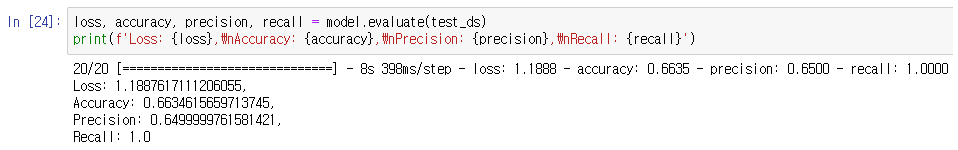

### 💛 7번째 시도 💛
- **5번째 시도의 전체 구성에서 shuffle_buffer_size의 값을 1000에서 1500으로 늘린 후** 성능 평가를 해본다.
- Accuracy 결과(%) : **83.974%**

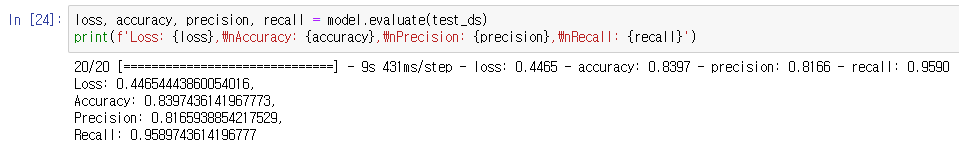

### 💛 8번째 시도 💛
- **5번째 시도의 전체 구성에서 shuffle_buffer_size의 값을 1000에서 2000으로 늘린 후** 성능 평가를 해본다.
- Accuracy 결과(%) : **73.717%**

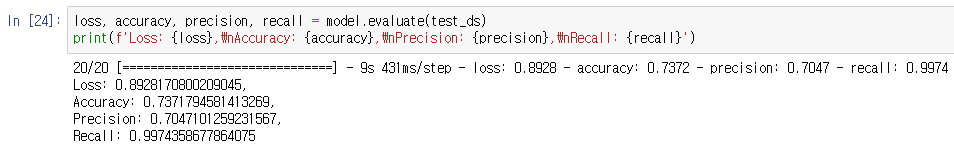

### 💛 9번째 시도 💛
- **shuffle_buffer_size의 값을 다시 1000으로 돌려놓고 재시도한다.**
- Accuracy 결과(%) : **88.782% (4번째 시도의 기록 갱신)**

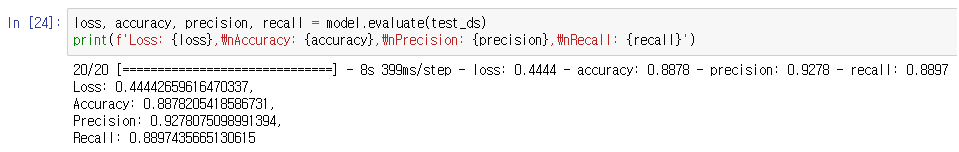

### 💙 중간 점검 💙
- **shuffle_buffer_size를 1000을 기준으로 500씩 늘리고 줄여서 한번씩 시도를 해 보았다.**
- 역시 처음 께 좋았나 보다..(^^;)

### 💛 10번째 시도 💛

- **참고 : 초기 build_model() 설정**

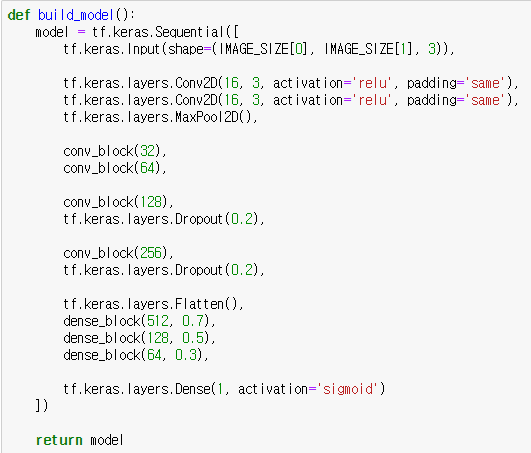

- 이제부터는 build_model 함수 내의 값들을 조정해서 성능을 테스트해 본다.
- **Conv2D Layer 16 → 32로 변경**
- Accuracy 결과(%) : **74.67%**

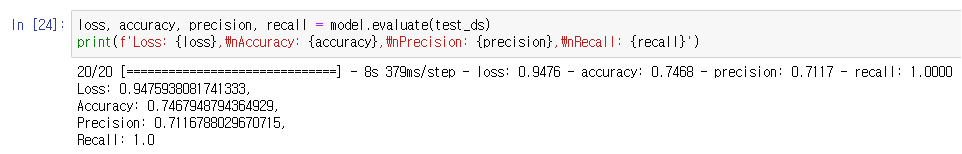

### 💛 11번째 시도 💛
- 초기 build_model 기준으로 **Conv block쪽 Dropout 값 모두 0.2 → 0.3으로 변경**
- Accuracy 결과(%) : **69.87%**

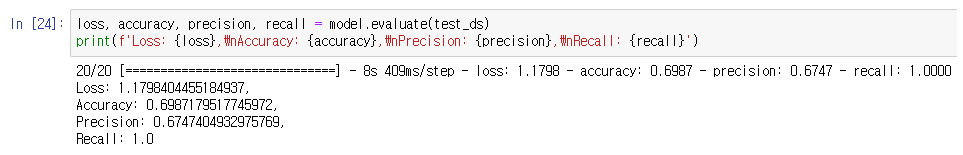

### 💛 12번째 시도 💛
- 초기 build_model 기준으로 **Conv block쪽 Dropout 값 모두 0.2 → 0.1로 변경**
- Accuracy 결과(%) : **83.49%**

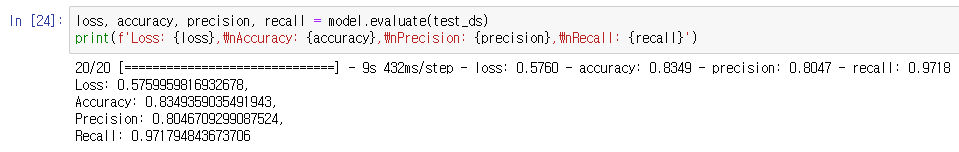

### 💛 13번째 시도 💛
- 초기 build_model 기준으로 **Conv2D Layer 16 → 8로 변경**
- Accuracy 결과(%) : **83.814%**

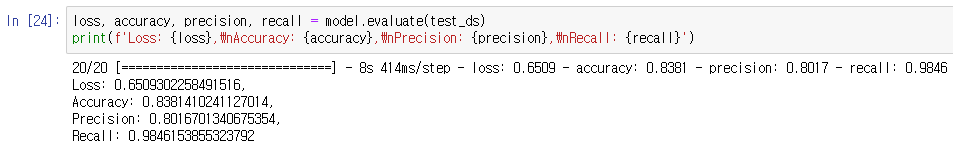

## 9. 프로젝트 회고

- 시간 관계상 서로 다른 구성으로 13번까지만 시도하고 프로젝트를 마무리한다.
- 시도해 본 결과를 토대로 봤을 때, 노드의 실습코드를 그대로 적용했을 때는 약 80% 내외의 Accuracy를 보였다.
- 하지만 BATCH_SIZE, EPOCHS, 모델의 레이어, Dropout 값, shuffle_buffer_size 등을 모두 조절해 가며 Accuracy 85%를 달성할 수 있었다.
- 간단하게 시도결과를 정리하면, 기존의 실습코드에서 **EPOCH 횟수를 10회로 조정**했을 때 다른 시도들보다 상대적으로 성능 개선도가 좋았다.
- 조금 더 고민을 해볼 수 있었겠지만, 기한상 더 시도 해보지 못하는 것은 아쉬운 점으로 남는다.
- Augmentation의 경우는 노드에서도 설명되어 있듯이 노이즈 등의 부수적인 효과들이 이미지 처리 과정에 방해가 될 수 있는 부분이 있어서, 이번 프로젝트에서는 별도로 시도하지는 않았다.